# User-Friendly Progressive Workflow Tutorial

In this notebook we present the a __user-friendly approach__ in the well-known ABT-BUY dataset. This is a simple approach, specially developed for novice users in Progressive ER.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# How to install?

pyJedAI is an open-source library that can be installed from PyPI.


In [2]:
!pip install pyjedai -U

In [3]:
!pip show pyjedai

Name: pyjedai
Version: 0.0.9
Summary: An open-source library that builds powerful end-to-end Entity Resolution workflows.
Home-page: 
Author: 
Author-email: Konstantinos Nikoletos <nikoletos.kon@gmail.com>, George Papadakis <gpapadis84@gmail.com>, Jakub Maciejewski <jacobb.maciejewski@gmail.com>
License: Apache Software License 2.0
Location: /home/conda/miniconda3/envs/pyjedai-progressive/lib/python3.9/site-packages
Requires: faiss-cpu, gensim, matplotlib, matplotlib-inline, networkx, nltk, numpy, optuna, ordered-set, pandas, pandas-profiling, pandocfilters, py-stringmatching, PyYAML, rdflib, rdfpandas, regex, scipy, seaborn, sentence-transformers, strsim, strsimpy, tomli, tqdm, transformers, valentine
Required-by: 


Imports

In [4]:
import os
import sys
import pandas as pd
from itertools import product

## Data Reading

In [5]:
from pyjedai.datamodel import Data

# data = Data(
#     dataset_1=pd.read_csv("../data/test/ccer/abt_100.csv", sep='|', engine='python', na_filter=False).astype(str),
#     attributes_1=['id','name','description'],
#     id_column_name_1='id',
#     dataset_2=pd.read_csv("../data/test/ccer/buy_100.csv", sep='|', engine='python', na_filter=False).astype(str),
#     attributes_2=['id','name','description'],
#     id_column_name_2='id',
#     ground_truth=pd.read_csv("../data/test/ccer/gt_100.csv", sep='|', engine='python'),
# )
data = Data(
    dataset_1=pd.read_csv("../data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=pd.read_csv("../data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=pd.read_csv("../data/ccer/D2/gt.csv", sep='|', engine='python'),
)

DATASET_NAME = "D100"

[nltk_data] Downloading package stopwords to /home/jm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Progressive WorkFlows

In [6]:
from pyjedai.workflow import ProgressiveWorkFlow
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking
)
from pyjedai.block_cleaning import (
    BlockFiltering,
    BlockPurging
)
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    ReciprocalWeightedNodePruning,
    ComparisonPropagation
)

from pyjedai.evaluation import (
    Evaluation
)

/home/conda/miniconda3/envs/pyjedai-progressive/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Budget, Scheduling & Emissions

The basic concept that trascends PER (Progressive Entity Scheduling):
Budget - The maximum number of pairs that our ER system can suggest for matching 


Progressive PER Methods execution can be broken up into *Two Phases*:

**1. Scheduling** - During this phase we produce a subset of the original fully connected dataset, where each entity could be a possible match candidate for any other entity in the source or target dataset. In this way, we obtain a neighborhood for each entity (group of possible candidates) and each of them is ascribed a score. 

**2. Emission** - During this phase, we iterate over the previously defined neighborhood with many different approaches (DFS, BFS, Hybrid, Top) and we extract the final candidates for matching within the defined budget.

# Budget Definition
In order to compare or evaluate the relative strength of a single or group of PER workflows, we execute them for different budget limits.
A popular approach is running the group of workflows we are interested in, for a budget set as multiples of the number of true positive duplicates in our ER task.

In [7]:
#That is why, we will run our experiments in a budget range up to 2 times the number of true positive duplicates
BUDGETS = [i * len(data.ground_truth) for i in range(1,3)]

## NN Based PER Workflows

In [8]:
# Those are the arguments that are available for NN based PER workflows
# They can be passed to the run function either in the form of an argument dictionary like the one above
# or you can simply define the arguments and their proper values in the parameters of the run function
available_nn_workflow_arguments = {
    "algorithm": ["DFS", "BFS", "HB", "TOP"],
    "number_of_nearest_neighbors": [1,2,3,4,5,6,7,8,9,10],
    "indexing": ["inorder", "reverse", "bilateral"],
    "language_model": ["word2vec", 
                    "fasttext",
                    "glove", 
                    "bert",
                    "distilbert",
                    "roberta",
                    "xlnet",
                    "albert",
                    "smpnet",
                    "st5",
                    "sent_glove",
                    "sdistilroberta", 
                    "sminilm"]
}

# We choose a group of NN based PER workflows that will be the product of a subset of the original, available arguments and values
example_nn_workflows_arguments = {
    "algorithm": ["HB"],
    "number_of_nearest_neighbors": [2,10],
    "indexing": ["inorder", "reverse"],
    "language_model": ["sminilm"]
}

# The name of our PER module 
nn_matcher = "EmbeddingsNNBPM"

In [9]:
nn_example_parameters = list(example_nn_workflows_arguments.keys())
nn_example_values = list(example_nn_workflows_arguments.values())
nn_example_workflow_combinations = list(product(*nn_example_values))

# total number of workflows that will be executed
total_workflows = len(nn_example_workflow_combinations) * len(BUDGETS)


nn_workflow_results = {}
workflows_count = 0
for budget in BUDGETS:
    for nn_example_workflow_combination in nn_example_workflow_combinations:
        # We setup the current workflow's arguments
        nn_example_workflow_arguments = dict(zip(nn_example_parameters, nn_example_workflow_combination))
        
        # Current workflow is being executed with the given arguments combination
        workflows_count += 1
        print(f"#### WORKFLOW {workflows_count}/{total_workflows} ####")
        nn_example_workflow = ProgressiveWorkFlow()
        nn_example_workflow.run(data=data,
                            block_building=None,
                            block_purging=None,
                            block_filtering=None,
                            matcher=nn_matcher,
                            budget=budget,
                            dataset=DATASET_NAME,
                            **nn_example_workflow_arguments)
        
        
        # We add the last executed workflow into our final results
        nn_example_workflow_info = nn_example_workflow.save(arguments=nn_example_workflow_arguments,
                                                            results=nn_workflow_results)
        
        # We print current workflow information
        nn_example_workflow.print_info(info=nn_example_workflow_info)

#### WORKFLOW 1/8 ####
{'language_model': 'sminilm', 'number_of_nearest_neighbors': 2}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Embeddings NN Blocking Based Progressive Matching: 0it [00:00, ?it/s]

Building blocks via Embeddings-NN Block Building [sminilm, faiss]



Embeddings-NN Block Building [sminilm, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

Device selected:  cuda



Embeddings-NN Block Building [sminilm, faiss]: 100%|██████████| 2152/2152 [00:16<00:00, 133.43it/s]
Embeddings NN Blocking Based Progressive Matching: 0it [00:16, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : inorder
language_model : sminilm
total_candidates : 1076
total_emissions : 1076
time : 16.15586543083191
name : fb637719-65f1-4cef-85ad-eadbbfb512d2
true_positives : 713
dataset : D100
matcher : EmbeddingsNNBPM
#### WORKFLOW 2/8 ####
{'language_model': 'sminilm', 'number_of_nearest_neighbors': 2}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'reverse'}


Embeddings NN Blocking Based Progressive Matching: 0it [00:00, ?it/s]

Building blocks via Embeddings-NN Block Building [sminilm, faiss]



Embeddings-NN Block Building [sminilm, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

Device selected:  cuda



Embeddings-NN Block Building [sminilm, faiss]: 100%|██████████| 2152/2152 [00:13<00:00, 157.03it/s]
Embeddings NN Blocking Based Progressive Matching: 0it [00:13, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : reverse
language_model : sminilm
total_candidates : 1076
total_emissions : 1076
time : 13.753221035003662
name : b54051c1-2c00-40a4-8334-01576e0e9e4b
true_positives : 709
dataset : D100
matcher : EmbeddingsNNBPM
#### WORKFLOW 3/8 ####
{'language_model': 'sminilm', 'number_of_nearest_neighbors': 10}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Embeddings NN Blocking Based Progressive Matching: 0it [00:00, ?it/s]

Building blocks via Embeddings-NN Block Building [sminilm, faiss]



Embeddings-NN Block Building [sminilm, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

Device selected:  cuda



Embeddings-NN Block Building [sminilm, faiss]: 100%|██████████| 2152/2152 [00:12<00:00, 172.76it/s]
Embeddings NN Blocking Based Progressive Matching: 0it [00:12, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : inorder
language_model : sminilm
total_candidates : 1076
total_emissions : 1076
time : 12.514333486557007
name : 08df599b-de5f-47d5-bbff-29ef1df1d79d
true_positives : 681
dataset : D100
matcher : EmbeddingsNNBPM
#### WORKFLOW 4/8 ####
{'language_model': 'sminilm', 'number_of_nearest_neighbors': 10}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'reverse'}


Embeddings NN Blocking Based Progressive Matching: 0it [00:00, ?it/s]

Building blocks via Embeddings-NN Block Building [sminilm, faiss]



Embeddings-NN Block Building [sminilm, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

Device selected:  cuda



Embeddings-NN Block Building [sminilm, faiss]: 100%|██████████| 2152/2152 [00:13<00:00, 155.30it/s]
Embeddings NN Blocking Based Progressive Matching: 0it [00:13, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : reverse
language_model : sminilm
total_candidates : 1076
total_emissions : 1076
time : 13.998786687850952
name : f4716024-d72c-4819-a9c8-6e99dc856ad1
true_positives : 709
dataset : D100
matcher : EmbeddingsNNBPM
#### WORKFLOW 5/8 ####
{'language_model': 'sminilm', 'number_of_nearest_neighbors': 2}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Embeddings NN Blocking Based Progressive Matching: 0it [00:00, ?it/s]

Building blocks via Embeddings-NN Block Building [sminilm, faiss]



Embeddings-NN Block Building [sminilm, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

Device selected:  cuda



Embeddings-NN Block Building [sminilm, faiss]: 100%|██████████| 2152/2152 [00:15<00:00, 142.60it/s]
Embeddings NN Blocking Based Progressive Matching: 0it [00:15, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : inorder
language_model : sminilm
total_candidates : 2152
total_emissions : 2152
time : 15.132911443710327
name : 14e52b8c-ab66-47c7-b6be-70a63030e43b
true_positives : 863
dataset : D100
matcher : EmbeddingsNNBPM
#### WORKFLOW 6/8 ####
{'language_model': 'sminilm', 'number_of_nearest_neighbors': 2}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'reverse'}


Embeddings NN Blocking Based Progressive Matching: 0it [00:00, ?it/s]

Building blocks via Embeddings-NN Block Building [sminilm, faiss]



Embeddings-NN Block Building [sminilm, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

Device selected:  cuda



Embeddings-NN Block Building [sminilm, faiss]: 100%|██████████| 2152/2152 [00:14<00:00, 151.79it/s]
Embeddings NN Blocking Based Progressive Matching: 0it [00:14, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : reverse
language_model : sminilm
total_candidates : 2152
total_emissions : 2152
time : 14.236016750335693
name : 75346db7-a352-4af7-a2da-193ecc77b543
true_positives : 826
dataset : D100
matcher : EmbeddingsNNBPM
#### WORKFLOW 7/8 ####
{'language_model': 'sminilm', 'number_of_nearest_neighbors': 10}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Embeddings NN Blocking Based Progressive Matching: 0it [00:00, ?it/s]

Building blocks via Embeddings-NN Block Building [sminilm, faiss]



Embeddings-NN Block Building [sminilm, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

Device selected:  cuda



Embeddings-NN Block Building [sminilm, faiss]: 100%|██████████| 2152/2152 [00:12<00:00, 167.06it/s]
Embeddings NN Blocking Based Progressive Matching: 0it [00:12, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : inorder
language_model : sminilm
total_candidates : 2152
total_emissions : 2152
time : 12.951519250869751
name : 913e6765-afdc-4da4-9bbe-562e2e0936e8
true_positives : 726
dataset : D100
matcher : EmbeddingsNNBPM
#### WORKFLOW 8/8 ####
{'language_model': 'sminilm', 'number_of_nearest_neighbors': 10}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'reverse'}


Embeddings NN Blocking Based Progressive Matching: 0it [00:00, ?it/s]

Building blocks via Embeddings-NN Block Building [sminilm, faiss]



Embeddings-NN Block Building [sminilm, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

Device selected:  cuda



Embeddings-NN Block Building [sminilm, faiss]: 100%|██████████| 2152/2152 [00:15<00:00, 142.03it/s]
Embeddings NN Blocking Based Progressive Matching: 0it [00:15, ?it/s]

algorithm : HB
number_of_nearest_neighbors : 10
indexing : reverse
language_model : sminilm
total_candidates : 2152
total_emissions : 2152
time : 15.411551237106323
name : 735c1bc0-9669-4bad-85e3-a319ff3875bc
true_positives : 754
dataset : D100
matcher : EmbeddingsNNBPM


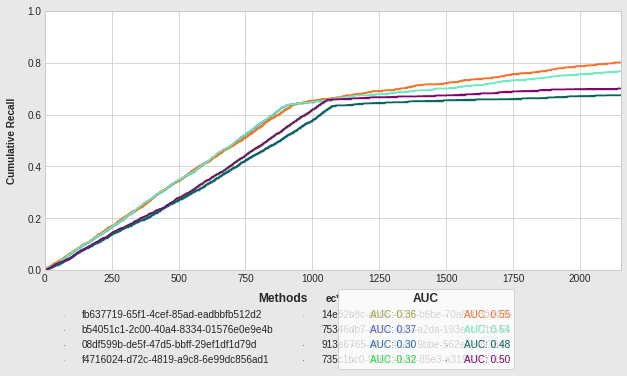

{'D100': {'EmbeddingsNNBPM': {'sminilm': [{'algorithm': 'HB', 'number_of_nearest_neighbors': 2, 'indexing': 'inorder', 'language_model': 'sminilm', 'total_candidates': 1076, 'total_emissions': 1076, 'time': 16.15586543083191, 'name': 'fb637719-65f1-4cef-85ad-eadbbfb512d2', 'dataset': 'D100', 'matcher': 'EmbeddingsNNBPM', 'auc': 0.3647609875980712, 'recall': 0.662639405204461}, {'algorithm': 'HB', 'number_of_nearest_neighbors': 2, 'indexing': 'reverse', 'language_model': 'sminilm', 'total_candidates': 1076, 'total_emissions': 1076, 'time': 13.753221035003662, 'name': 'b54051c1-2c00-40a4-8334-01576e0e9e4b', 'dataset': 'D100', 'matcher': 'EmbeddingsNNBPM', 'auc': 0.3660898889590723, 'recall': 0.6589219330855018}, {'algorithm': 'HB', 'number_of_nearest_neighbors': 10, 'indexing': 'inorder', 'language_model': 'sminilm', 'total_candidates': 1076, 'total_emissions': 1076, 'time': 12.514333486557007, 'name': '08df599b-de5f-47d5-bbff-29ef1df1d79d', 'dataset': 'D100', 'matcher': 'EmbeddingsNNBPM

In [30]:
# We can calculate the AUC / visualize the ROC for each of the executed workflows
# Bear in mind the curves' legends contain the randomly generated identifier for each workflow
evaluator = Evaluation(data)
evaluator.visualize_results_roc(results=nn_workflow_results, drop_tp_indices=True)
# In order to understand which curve corresponds to which workflow:
# Search for the identifier within the workflows results dictionary 
print(nn_workflow_results)

## Sorted Neighborhood PER Workflows

In [20]:
# Those are the arguments that are available for Neighborhood-based PER workflows
# They can be passed to the run function either in the form of an argument dictionary like the one above
# or you can simply define the arguments and their proper values in the parameters of the run function
available_sn_workflow_arguments = {
    "algorithm": ["DFS", "BFS", "HB", "TOP"],
    "window_size": [1,2,3,4,5,6,7,8,9,10],
    "indexing": ["inorder"],
    "weighting_scheme": ["ACF", "ID"]
}

# We choose a group of Neighborhood-based PER workflows which will be the product of a subset of the original, available arguments and values
example_sn_workflows_arguments = {
    "algorithm": ["HB"],
    "window_size": [2,10],
    "indexing": ["inorder"],
    "weighting_scheme": ["ACF", "ID"]
}

# The name of our PER module 
sn_matcher = "LocalPSNM"

In [21]:
sn_example_parameters = list(example_sn_workflows_arguments.keys())
sn_example_values = list(example_sn_workflows_arguments.values())
sn_example_workflow_combinations = list(product(*sn_example_values))

# total number of workflows that will be executed
total_workflows = len(sn_example_workflow_combinations) * len(BUDGETS)


sn_workflow_results = {}
workflows_count = 0
for budget in BUDGETS:
    for sn_example_workflow_combination in sn_example_workflow_combinations:
        # We setup the current workflow's arguments
        sn_example_workflow_arguments = dict(zip(sn_example_parameters, sn_example_workflow_combination))
        
        # Current workflow is being executed with the given arguments combination
        workflows_count += 1
        print(f"#### WORKFLOW {workflows_count}/{total_workflows} ####")
        sn_example_workflow = ProgressiveWorkFlow()
        sn_example_workflow.run(data=data,
                            block_building=None,
                            block_purging=None,
                            block_filtering=None,
                            matcher=sn_matcher,
                            budget=budget,
                            dataset=DATASET_NAME,
                            **sn_example_workflow_arguments)    
        
        # We add the last executed workflow into our final results
        sn_example_workflow_info = sn_example_workflow.save(arguments=sn_example_workflow_arguments,
                                                            results=sn_workflow_results)
        
        # We print current workflow information
        sn_example_workflow.print_info(info=sn_example_workflow_info)

#### WORKFLOW 1/8 ####
{'weighting_scheme': 'ACF', 'window_size': 2}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Progressive Sorted Neighborhood Matching:   0%|          | 0/3019 [00:00<?, ?it/s]


algorithm : HB
window_size : 2
indexing : inorder
weighting_scheme : ACF
total_candidates : 1076
total_emissions : 1076
time : 0.6015763282775879
name : ff2f8e9d-e48e-442b-a1d3-6c10f9488320
true_positives : 289
dataset : D100
matcher : LocalPSNM
#### WORKFLOW 2/8 ####
{'weighting_scheme': 'ID', 'window_size': 2}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Progressive Sorted Neighborhood Matching:   0%|          | 0/3019 [00:00<?, ?it/s]


algorithm : HB
window_size : 2
indexing : inorder
weighting_scheme : ID
total_candidates : 1076
total_emissions : 1076
time : 0.3957831859588623
name : 8d837f80-66a4-4190-bd15-f0f3e9cfd3c3
true_positives : 289
dataset : D100
matcher : LocalPSNM
#### WORKFLOW 3/8 ####
{'weighting_scheme': 'ACF', 'window_size': 10}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Progressive Sorted Neighborhood Matching:   0%|          | 0/3019 [00:00<?, ?it/s]


algorithm : HB
window_size : 10
indexing : inorder
weighting_scheme : ACF
total_candidates : 1076
total_emissions : 1076
time : 1.216900110244751
name : fcc27185-fc2f-4238-a4f3-04fcec8888d4
true_positives : 233
dataset : D100
matcher : LocalPSNM
#### WORKFLOW 4/8 ####
{'weighting_scheme': 'ID', 'window_size': 10}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Progressive Sorted Neighborhood Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
window_size : 10
indexing : inorder
weighting_scheme : ID
total_candidates : 1076
total_emissions : 1076
time : 1.237194538116455
name : 20c24780-1dc8-4e5d-8ab1-7a88870edcca
true_positives : 256
dataset : D100
matcher : LocalPSNM
#### WORKFLOW 5/8 ####
{'weighting_scheme': 'ACF', 'window_size': 2}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Progressive Sorted Neighborhood Matching:   0%|          | 0/3019 [00:00<?, ?it/s]


algorithm : HB
window_size : 2
indexing : inorder
weighting_scheme : ACF
total_candidates : 2152
total_emissions : 2152
time : 0.405254602432251
name : 7a6f8ec1-3d03-40cf-998b-d04a7817ad11
true_positives : 303
dataset : D100
matcher : LocalPSNM
#### WORKFLOW 6/8 ####
{'weighting_scheme': 'ID', 'window_size': 2}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Progressive Sorted Neighborhood Matching:   0%|          | 0/3019 [00:00<?, ?it/s]


algorithm : HB
window_size : 2
indexing : inorder
weighting_scheme : ID
total_candidates : 2152
total_emissions : 2152
time : 0.5819246768951416
name : c7983279-1cc9-4d47-9ed3-358bdca3f42c
true_positives : 300
dataset : D100
matcher : LocalPSNM
#### WORKFLOW 7/8 ####
{'weighting_scheme': 'ACF', 'window_size': 10}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Progressive Sorted Neighborhood Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
window_size : 10
indexing : inorder
weighting_scheme : ACF
total_candidates : 2152
total_emissions : 2152
time : 1.2731971740722656
name : 7331d6a3-00f1-4e74-ac9f-1eb13a6a1cd9
true_positives : 256
dataset : D100
matcher : LocalPSNM
#### WORKFLOW 8/8 ####
{'weighting_scheme': 'ID', 'window_size': 10}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Progressive Sorted Neighborhood Matching:   0%|          | 0/3019 [00:00<?, ?it/s]

algorithm : HB
window_size : 10
indexing : inorder
weighting_scheme : ID
total_candidates : 2152
total_emissions : 2152
time : 1.089101791381836
name : 88d1d25d-50d8-42b4-ab14-14a840b6d6b0
true_positives : 273
dataset : D100
matcher : LocalPSNM


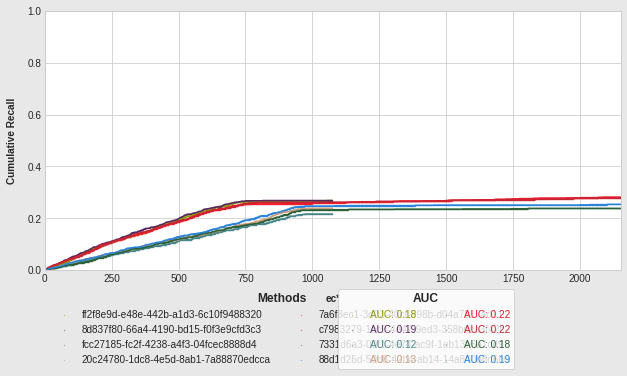

{'D100': {'LocalPSNM': [{'algorithm': 'HB', 'window_size': 2, 'indexing': 'inorder', 'weighting_scheme': 'ACF', 'total_candidates': 1076, 'total_emissions': 1076, 'time': 0.6015763282775879, 'name': 'ff2f8e9d-e48e-442b-a1d3-6c10f9488320', 'dataset': 'D100', 'matcher': 'LocalPSNM', 'auc': 0.18259708746242076, 'recall': 0.26858736059479554}, {'algorithm': 'HB', 'window_size': 2, 'indexing': 'inorder', 'weighting_scheme': 'ID', 'total_candidates': 1076, 'total_emissions': 1076, 'time': 0.3957831859588623, 'name': '8d837f80-66a4-4190-bd15-f0f3e9cfd3c3', 'dataset': 'D100', 'matcher': 'LocalPSNM', 'auc': 0.18648714417372006, 'recall': 0.26858736059479554}, {'algorithm': 'HB', 'window_size': 10, 'indexing': 'inorder', 'weighting_scheme': 'ACF', 'total_candidates': 1076, 'total_emissions': 1076, 'time': 1.216900110244751, 'name': 'fcc27185-fc2f-4238-a4f3-04fcec8888d4', 'dataset': 'D100', 'matcher': 'LocalPSNM', 'auc': 0.11882794351651411, 'recall': 0.21654275092936803}, {'algorithm': 'HB', 'wi

In [29]:
# We can calculate the AUC / visualize the ROC for each of the executed workflows
# Bear in mind the curves' legends contain the randomly generated identifier for each workflow
evaluator = Evaluation(data)
evaluator.visualize_results_roc(results=sn_workflow_results, drop_tp_indices=True)
# In order to understand which curve corresponds to which workflow:
# Search for the identifier within the workflows results dictionary 
print(sn_workflow_results)

In [14]:
## MB PER Workflows

In [23]:
# Those are the arguments that are available for MB-based PER workflows
# They can be passed to the run function either in the form of an argument dictionary like the one above
# or you can simply define the arguments and their proper values in the parameters of the run function
available_mb_workflow_arguments = {
    "algorithm": ["DFS", "BFS", "HB", "TOP"],
    "number_of_nearest_neighbors": [1,2,3,4,5,6,7,8,9,10],
    "indexing": ["inorder"],
    "weighting_scheme": ["CN-CBS", "CBS", "SN-CBS", "CNC", "SNC", "CND", "SND", "CNJ", "SNJ", "COSINE", "DICE", "ECBS", "JS", "EJS", "X2"]
}

# We choose a group of MB-based PER workflows which will be the product of a subset of the original, available arguments and values
example_mb_workflows_arguments = {
    "algorithm": ["HB"],
    "number_of_nearest_neighbors": [2,10],
    "indexing": ["inorder"],
    "weighting_scheme": ["SN-CBS", "EJS"]
}

# MB PER Workflows are based upon the concept of scheduling through block building, filtering and purging
# User can define a dictionary with the block building/filtering/purging module of their choice and its corresponding arguments as follows:
MB_BLOCK_BUILDING = dict(method=StandardBlocking, 
                        params=dict())

MB_BLOCK_FILTERING = dict(method=BlockFiltering, 
                        params=dict(ratio=0.8))

MB_BLOCK_PURGING = dict(method=BlockPurging, 
                        params=dict(smoothing_factor=1.0)) 

# The name of our PER module 
mb_matcher = "LocalTopPM"

In [34]:
mb_example_parameters = list(example_mb_workflows_arguments.keys())
mb_example_values = list(example_mb_workflows_arguments.values())
mb_example_workflow_combinations = list(product(*mb_example_values))

# total number of workflows that will be executed
total_workflows = len(mb_example_workflow_combinations) * len(BUDGETS)


mb_workflow_results = {}
workflows_count = 0
print(BUDGETS)
for budget in BUDGETS:
    for mb_example_workflow_combination in mb_example_workflow_combinations:
        # We setup the current workflow's arguments
        mb_example_workflow_arguments = dict(zip(mb_example_parameters, mb_example_workflow_combination))
        
        # Current workflow is being executed with the given arguments combination
        workflows_count += 1
        print(f"#### WORKFLOW {workflows_count}/{total_workflows} ####")
        mb_example_workflow = ProgressiveWorkFlow()
        mb_example_workflow.run(data=data,
                            block_building=MB_BLOCK_BUILDING,
                            block_purging=MB_BLOCK_FILTERING,
                            block_filtering=MB_BLOCK_PURGING,
                            matcher=mb_matcher,
                            budget=budget,
                            dataset=DATASET_NAME,
                            **mb_example_workflow_arguments)    
        
        # We add the last executed workflow into our final results
        mb_example_workflow_info = mb_example_workflow.save(arguments=mb_example_workflow_arguments,
                                                            results=mb_workflow_results)
        
        # We print current workflow information
        mb_example_workflow.print_info(info=mb_example_workflow_info)

[1076, 2152]
#### WORKFLOW 1/8 ####
{'weighting_scheme': 'SN_CBS', 'number_of_nearest_neighbors': 2}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Top Progressive Matching:   0%|          | 0/2827 [00:00<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : inorder
weighting_scheme : SN_CBS
total_candidates : 1076
total_emissions : 1076
time : 0.7439219951629639
name : 3de193ba-c967-4b74-9b4d-44be3add7d25
true_positives : 585
dataset : D100
matcher : LocalTopPM
#### WORKFLOW 2/8 ####
{'weighting_scheme': 'EJS', 'number_of_nearest_neighbors': 2}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Top Progressive Matching:   0%|          | 0/2827 [00:00<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : inorder
weighting_scheme : EJS
total_candidates : 1076
total_emissions : 1076
time : 0.6373767852783203
name : af0fd8bc-cb7e-4e2b-a572-32421a822dd0
true_positives : 678
dataset : D100
matcher : LocalTopPM
#### WORKFLOW 3/8 ####
{'weighting_scheme': 'SN_CBS', 'number_of_nearest_neighbors': 10}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Top Progressive Matching:   0%|          | 0/2827 [00:00<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : inorder
weighting_scheme : SN_CBS
total_candidates : 1076
total_emissions : 1076
time : 0.5188391208648682
name : 70b5750d-7bb9-49f4-9787-89713c5eac3d
true_positives : 563
dataset : D100
matcher : LocalTopPM
#### WORKFLOW 4/8 ####
{'weighting_scheme': 'EJS', 'number_of_nearest_neighbors': 10}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Top Progressive Matching:   0%|          | 0/2827 [00:00<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : inorder
weighting_scheme : EJS
total_candidates : 1076
total_emissions : 1076
time : 0.8967716693878174
name : 44c38357-04ef-4e1a-b8c8-82a5b7bd493e
true_positives : 679
dataset : D100
matcher : LocalTopPM
#### WORKFLOW 5/8 ####
{'weighting_scheme': 'SN_CBS', 'number_of_nearest_neighbors': 2}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Top Progressive Matching:   0%|          | 0/2827 [00:00<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : inorder
weighting_scheme : SN_CBS
total_candidates : 2152
total_emissions : 2152
time : 0.4133322238922119
name : 9e01ecaa-aaf9-41c2-9ae7-adfdea175dda
true_positives : 728
dataset : D100
matcher : LocalTopPM
#### WORKFLOW 6/8 ####
{'weighting_scheme': 'EJS', 'number_of_nearest_neighbors': 2}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Top Progressive Matching:   0%|          | 0/2827 [00:00<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : inorder
weighting_scheme : EJS
total_candidates : 2152
total_emissions : 2152
time : 0.6276335716247559
name : 91a30812-f746-45ed-87b0-83370fa2489b
true_positives : 773
dataset : D100
matcher : LocalTopPM
#### WORKFLOW 7/8 ####
{'weighting_scheme': 'SN_CBS', 'number_of_nearest_neighbors': 10}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Top Progressive Matching:   0%|          | 0/2827 [00:00<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : inorder
weighting_scheme : SN_CBS
total_candidates : 2152
total_emissions : 2152
time : 0.6860294342041016
name : a3aa59dd-dfb0-4b4b-82d6-466f99491b9f
true_positives : 602
dataset : D100
matcher : LocalTopPM
#### WORKFLOW 8/8 ####
{'weighting_scheme': 'EJS', 'number_of_nearest_neighbors': 10}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Global Top Progressive Matching:   0%|          | 0/2827 [00:00<?, ?it/s]

algorithm : HB
number_of_nearest_neighbors : 10
indexing : inorder
weighting_scheme : EJS
total_candidates : 2152
total_emissions : 2152
time : 0.7056057453155518
name : c911c0be-060b-4e21-a795-6026508d7a25
true_positives : 707
dataset : D100
matcher : LocalTopPM


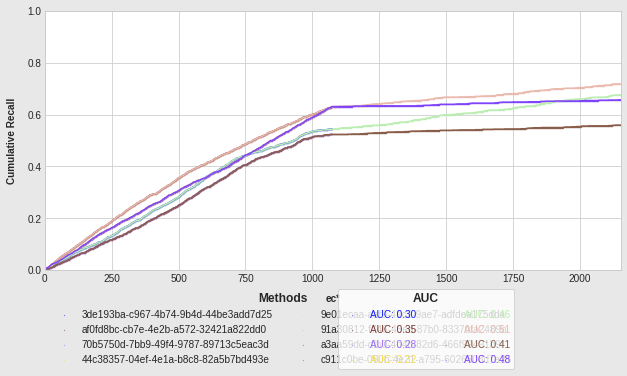

{'D100': {'LocalTopPM': [{'algorithm': 'HB', 'number_of_nearest_neighbors': 2, 'indexing': 'inorder', 'weighting_scheme': 'SN_CBS', 'total_candidates': 1076, 'total_emissions': 1076, 'time': 0.7439219951629639, 'name': '3de193ba-c967-4b74-9b4d-44be3add7d25', 'dataset': 'D100', 'matcher': 'LocalTopPM', 'auc': 0.3009676818092379, 'recall': 0.5436802973977695}, {'algorithm': 'HB', 'number_of_nearest_neighbors': 2, 'indexing': 'inorder', 'weighting_scheme': 'EJS', 'total_candidates': 1076, 'total_emissions': 1076, 'time': 0.6373767852783203, 'name': 'af0fd8bc-cb7e-4e2b-a572-32421a822dd0', 'dataset': 'D100', 'matcher': 'LocalTopPM', 'auc': 0.3541461722463265, 'recall': 0.6301115241635687}, {'algorithm': 'HB', 'number_of_nearest_neighbors': 10, 'indexing': 'inorder', 'weighting_scheme': 'SN_CBS', 'total_candidates': 1076, 'total_emissions': 1076, 'time': 0.5188391208648682, 'name': '70b5750d-7bb9-49f4-9787-89713c5eac3d', 'dataset': 'D100', 'matcher': 'LocalTopPM', 'auc': 0.2755727219696736, 

In [35]:
# We can calculate the AUC / visualize the ROC for each of the executed workflows
# Bear in mind the curves' legends contain the randomly generated identifier for each workflow
evaluator = Evaluation(data)
evaluator.visualize_results_roc(results=mb_workflow_results, drop_tp_indices=True)
# In order to understand which curve corresponds to which workflow:
# Search for the identifier within the workflows results dictionary 
print(mb_workflow_results)

## Join PER Workflows

In [36]:
# Those are the arguments that are available for Join-based PER workflows
# They can be passed to the run function either in the form of an argument dictionary like the one above
# or you can simply define the arguments and their proper values in the parameters of the run function
available_jn_workflow_arguments = {
    "algorithm": ["DFS", "BFS", "HB", "TOP"],
    "number_of_nearest_neighbors": [1,2,3,4,5,6,7,8,9,10],
    "indexing": ["inorder", "reverse", "bilateral"],
    "similarity_function": ["cosine", "dice", "jaccard"],
    "tokenizer": ["qgrams", "standard", "standard_multiset", "qgrams_multiset"],
    "qgram": [1,2,3,4,5],
}

# We choose a group of Join-based PER workflows which will be the product of a subset of the original, available arguments and values
example_jn_workflows_arguments = {
    "algorithm": ["HB"],
    "number_of_nearest_neighbors": [2,10],
    "indexing": ["inorder", "reverse"],
    "similarity_function": ["cosine"],
    "tokenizer": ["qgrams", "standard"],
    "qgram": [2,5]
}

# The name of our PER module 
jn_matcher = "TopKJoinPM"

In [37]:
jn_example_parameters = list(example_jn_workflows_arguments.keys())
jn_example_values = list(example_jn_workflows_arguments.values())
jn_example_workflow_combinations = list(product(*jn_example_values))

# total number of workflows that will be executed
total_workflows = len(jn_example_workflow_combinations) * len(BUDGETS)


jn_workflow_results = {}
workflows_count = 0
print(BUDGETS)
for budget in BUDGETS:
    for jn_example_workflow_combination in jn_example_workflow_combinations:
        # We setup the current workflow's arguments
        jn_example_workflow_arguments = dict(zip(jn_example_parameters, jn_example_workflow_combination))
        
        # Current workflow is being executed with the given arguments combination
        workflows_count += 1
        print(f"#### WORKFLOW {workflows_count}/{total_workflows} ####")
        jn_example_workflow = ProgressiveWorkFlow()
        jn_example_workflow.run(data=data,
                            block_building=None,
                            block_purging=None,
                            block_filtering=None,
                            matcher=jn_matcher,
                            budget=budget,
                            dataset=DATASET_NAME,
                            **jn_example_workflow_arguments)    
        
        # We add the last executed workflow into our final results
        jn_example_workflow_info = jn_example_workflow.save(arguments=jn_example_workflow_arguments,
                                                            results=jn_workflow_results)
        
        # We print current workflow information
        jn_example_workflow.print_info(info=jn_example_workflow_info)

[1076, 2152]
#### WORKFLOW 1/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'qgrams', 'qgram': 2}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:13<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : inorder
similarity_function : cosine
tokenizer : qgrams
qgram : 2
total_candidates : 1076
total_emissions : 1076
time : 13.497895956039429
name : de4fa4e7-b255-44f7-8077-e71d096bc25b
true_positives : 734
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 2/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'qgrams', 'qgram': 5}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:02<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : inorder
similarity_function : cosine
tokenizer : qgrams
qgram : 5
total_candidates : 1076
total_emissions : 1076
time : 2.5070173740386963
name : 73828cd7-743e-40a4-ab81-41e91c8ebf90
true_positives : 742
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 3/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'standard', 'qgram': 2}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : inorder
similarity_function : cosine
tokenizer : standard
qgram : 2
total_candidates : 1076
total_emissions : 1076
time : 1.5485179424285889
name : 90e986a3-fbf8-4652-9e04-45752fc72bc4
true_positives : 735
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 4/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'standard', 'qgram': 5}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : inorder
similarity_function : cosine
tokenizer : standard
qgram : 5
total_candidates : 1076
total_emissions : 1076
time : 1.305600881576538
name : f631331e-97c2-4d6a-9205-1fbef5328b5b
true_positives : 735
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 5/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'qgrams', 'qgram': 2}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:12<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : reverse
similarity_function : cosine
tokenizer : qgrams
qgram : 2
total_candidates : 1076
total_emissions : 1076
time : 13.24766230583191
name : 1d02b7b0-badb-40b0-9e0e-4fe9e3b31b64
true_positives : 740
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 6/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'qgrams', 'qgram': 5}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:02<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : reverse
similarity_function : cosine
tokenizer : qgrams
qgram : 5
total_candidates : 1076
total_emissions : 1076
time : 2.3243024349212646
name : c5b29eb4-b3ab-46b8-8ed1-eb5de4476266
true_positives : 733
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 7/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'standard', 'qgram': 2}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : reverse
similarity_function : cosine
tokenizer : standard
qgram : 2
total_candidates : 1076
total_emissions : 1076
time : 1.4356060028076172
name : 8e4764c7-00fc-4c30-8390-b56bbea1f06e
true_positives : 720
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 8/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'standard', 'qgram': 5}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : reverse
similarity_function : cosine
tokenizer : standard
qgram : 5
total_candidates : 1076
total_emissions : 1076
time : 1.5821354389190674
name : 160e27fa-cc24-4482-8c26-35483cf1361f
true_positives : 720
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 9/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'qgrams', 'qgram': 2}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:13<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : inorder
similarity_function : cosine
tokenizer : qgrams
qgram : 2
total_candidates : 1076
total_emissions : 1076
time : 13.244184494018555
name : 0d5e00ab-32e2-44ba-8540-440a7ebb087a
true_positives : 610
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 10/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'qgrams', 'qgram': 5}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : inorder
similarity_function : cosine
tokenizer : qgrams
qgram : 5
total_candidates : 1076
total_emissions : 1076
time : 2.2989444732666016
name : 60bd6e3e-6341-470b-a670-c79d691b215f
true_positives : 718
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 11/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'standard', 'qgram': 2}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : inorder
similarity_function : cosine
tokenizer : standard
qgram : 2
total_candidates : 1076
total_emissions : 1076
time : 1.502495527267456
name : 7126bca1-2548-4076-bd6d-643b5bbccba7
true_positives : 711
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 12/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'standard', 'qgram': 5}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : inorder
similarity_function : cosine
tokenizer : standard
qgram : 5
total_candidates : 1076
total_emissions : 1076
time : 1.3352453708648682
name : 35051493-2a9b-4a10-8e7c-5e9973af09a4
true_positives : 711
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 13/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'qgrams', 'qgram': 2}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:13<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : reverse
similarity_function : cosine
tokenizer : qgrams
qgram : 2
total_candidates : 1076
total_emissions : 1076
time : 13.59870433807373
name : 7c71046e-e93e-4e3d-9ef3-3dedc88c7db7
true_positives : 740
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 14/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'qgrams', 'qgram': 5}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:02<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : reverse
similarity_function : cosine
tokenizer : qgrams
qgram : 5
total_candidates : 1076
total_emissions : 1076
time : 2.5377771854400635
name : 8fe00db0-f62b-4ef0-9ee0-cec6b13c3d43
true_positives : 733
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 15/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'standard', 'qgram': 2}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : reverse
similarity_function : cosine
tokenizer : standard
qgram : 2
total_candidates : 1076
total_emissions : 1076
time : 1.6483306884765625
name : 7f748ed3-0319-4073-9b2d-60bcfc7972be
true_positives : 720
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 16/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'standard', 'qgram': 5}
{'budget': 1076, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : reverse
similarity_function : cosine
tokenizer : standard
qgram : 5
total_candidates : 1076
total_emissions : 1076
time : 1.616624116897583
name : dfb31df0-1678-4a4b-b3ff-66c2dd925839
true_positives : 720
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 17/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'qgrams', 'qgram': 2}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:13<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : inorder
similarity_function : cosine
tokenizer : qgrams
qgram : 2
total_candidates : 2152
total_emissions : 2152
time : 13.44297742843628
name : 0aeded0b-ed95-46bc-98e2-0ebad27d3ecd
true_positives : 873
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 18/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'qgrams', 'qgram': 5}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : inorder
similarity_function : cosine
tokenizer : qgrams
qgram : 5
total_candidates : 2152
total_emissions : 2152
time : 2.3466145992279053
name : 014d47c4-140a-4e04-af62-9af12bae735f
true_positives : 851
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 19/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'standard', 'qgram': 2}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : inorder
similarity_function : cosine
tokenizer : standard
qgram : 2
total_candidates : 2152
total_emissions : 2152
time : 1.4424490928649902
name : 8c95720d-b8fd-4575-baf6-20534c1b01a1
true_positives : 820
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 20/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'standard', 'qgram': 5}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : inorder
similarity_function : cosine
tokenizer : standard
qgram : 5
total_candidates : 2152
total_emissions : 2152
time : 1.2243101596832275
name : f34edb81-d7a1-4fe2-89a4-3ab7371ad67f
true_positives : 820
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 21/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'qgrams', 'qgram': 2}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:12<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : reverse
similarity_function : cosine
tokenizer : qgrams
qgram : 2
total_candidates : 2152
total_emissions : 2152
time : 12.712459325790405
name : 4a50fda3-2788-4c2a-86ae-f67732582fd9
true_positives : 875
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 22/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'qgrams', 'qgram': 5}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : reverse
similarity_function : cosine
tokenizer : qgrams
qgram : 5
total_candidates : 2152
total_emissions : 2152
time : 2.2145018577575684
name : b2d454da-774a-48af-9811-5f0949f44e00
true_positives : 858
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 23/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'standard', 'qgram': 2}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : reverse
similarity_function : cosine
tokenizer : standard
qgram : 2
total_candidates : 2152
total_emissions : 2152
time : 1.3802013397216797
name : 403bb9ec-e533-445c-8d35-2e263e0a411f
true_positives : 820
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 24/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 2, 'tokenizer': 'standard', 'qgram': 5}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 2
indexing : reverse
similarity_function : cosine
tokenizer : standard
qgram : 5
total_candidates : 2152
total_emissions : 2152
time : 1.386265754699707
name : d92c1718-6a81-4b70-9a19-e5b58a550016
true_positives : 820
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 25/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'qgrams', 'qgram': 2}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:12<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : inorder
similarity_function : cosine
tokenizer : qgrams
qgram : 2
total_candidates : 2152
total_emissions : 2152
time : 12.794157028198242
name : 1ad182fa-d698-4ea1-a7e8-b0c85b500c7e
true_positives : 645
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 26/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'qgrams', 'qgram': 5}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:02<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : inorder
similarity_function : cosine
tokenizer : qgrams
qgram : 5
total_candidates : 2152
total_emissions : 2152
time : 2.518672227859497
name : 25d22785-3090-47f7-947c-f114e16cf963
true_positives : 760
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 27/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'standard', 'qgram': 2}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : inorder
similarity_function : cosine
tokenizer : standard
qgram : 2
total_candidates : 2152
total_emissions : 2152
time : 1.3608503341674805
name : b94d14a1-4b8f-4324-ae89-384eb2241399
true_positives : 735
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 28/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'standard', 'qgram': 5}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'inorder'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : inorder
similarity_function : cosine
tokenizer : standard
qgram : 5
total_candidates : 2152
total_emissions : 2152
time : 1.5844826698303223
name : 92a011ce-7369-42ff-8b5e-3d9ed1680424
true_positives : 735
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 29/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'qgrams', 'qgram': 2}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:13<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : reverse
similarity_function : cosine
tokenizer : qgrams
qgram : 2
total_candidates : 2152
total_emissions : 2152
time : 13.783488750457764
name : a1161b4c-1116-418f-8140-36e62f350246
true_positives : 783
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 30/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'qgrams', 'qgram': 5}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:02<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : reverse
similarity_function : cosine
tokenizer : qgrams
qgram : 5
total_candidates : 2152
total_emissions : 2152
time : 2.597332000732422
name : c98c918f-bd1e-4b63-8af0-e3029bba1cc1
true_positives : 771
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 31/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'standard', 'qgram': 2}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]


algorithm : HB
number_of_nearest_neighbors : 10
indexing : reverse
similarity_function : cosine
tokenizer : standard
qgram : 2
total_candidates : 2152
total_emissions : 2152
time : 1.436697006225586
name : 6fdfcc4f-1513-47e1-a940-c1c747a637b5
true_positives : 764
dataset : D100
matcher : TopKJoinPM
#### WORKFLOW 32/32 ####
{'similarity_function': 'cosine', 'number_of_nearest_neighbors': 10, 'tokenizer': 'standard', 'qgram': 5}
{'budget': 2152, 'algorithm': 'HB', 'indexing': 'reverse'}


Top-K Join Progressive Matching:   0%|          | 0/3019 [00:01<?, ?it/s]

algorithm : HB
number_of_nearest_neighbors : 10
indexing : reverse
similarity_function : cosine
tokenizer : standard
qgram : 5
total_candidates : 2152
total_emissions : 2152
time : 1.641963005065918
name : dcb30429-d919-427c-b46e-e6b33bd74414
true_positives : 764
dataset : D100
matcher : TopKJoinPM


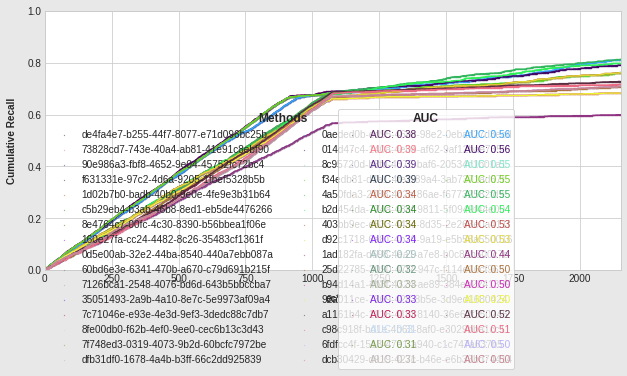

{'D100': {'TopKJoinPM': [{'algorithm': 'HB', 'number_of_nearest_neighbors': 2, 'indexing': 'inorder', 'similarity_function': 'cosine', 'tokenizer': 'qgrams', 'qgram': 2, 'total_candidates': 1076, 'total_emissions': 1076, 'time': 13.497895956039429, 'name': 'de4fa4e7-b255-44f7-8077-e71d096bc25b', 'dataset': 'D100', 'matcher': 'TopKJoinPM', 'auc': 0.3823413170965738, 'recall': 0.6821561338289963}, {'algorithm': 'HB', 'number_of_nearest_neighbors': 2, 'indexing': 'inorder', 'similarity_function': 'cosine', 'tokenizer': 'qgrams', 'qgram': 5, 'total_candidates': 1076, 'total_emissions': 1076, 'time': 2.5070173740386963, 'name': '73828cd7-743e-40a4-ab81-41e91c8ebf90', 'dataset': 'D100', 'matcher': 'TopKJoinPM', 'auc': 0.39318135534132115, 'recall': 0.6895910780669146}, {'algorithm': 'HB', 'number_of_nearest_neighbors': 2, 'indexing': 'inorder', 'similarity_function': 'cosine', 'tokenizer': 'standard', 'qgram': 2, 'total_candidates': 1076, 'total_emissions': 1076, 'time': 1.5485179424285889, 

In [39]:
# We can calculate the AUC / visualize the ROC for each of the executed workflows
# Bear in mind the curves' legends contain the randomly generated identifier for each workflow
evaluator = Evaluation(data)
evaluator.visualize_results_roc(results=jn_workflow_results, drop_tp_indices=True)
# In order to understand which curve corresponds to which workflow:
# Search for the identifier within the workflows results dictionary 
print(jn_workflow_results)

<hr>
<div align="right">
K. Nikoletos, J. Maciejewski, G. Papadakis & M. Koubarakis
</div>
<div align="right">
<a href="https://github.com/Nikoletos-K/pyJedAI/blob/main/LICENSE">Apache License 2.0</a>
</div>